In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
from scipy.integrate import quad
from scipy.spatial.distance import jensenshannon
from optimalEstimation import *

In [2]:
timelist = np.load('/home/penny/works/psd/inputs/radar_timelist.npy')
#32速度（m/s）
D = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,
              1.1875,1.375,1.625,1.875,2.125,2.375,2.75,3.25,3.75,4.25,4.75,5.5,
              6.5,7.5,8.5,9.5,11,13,15,17,19,21.5,24.5])
#32直径（mm）
V = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.1,1.3,1.5,1.7,
              1.9,2.2,2.6,3,3.4,3.8,4.4,5.2,6,6.8,7.6,8.8,10.4,12,13.6,15.2,
              17.6,20.8])

D[8:24] = (1.075 - 0.075*D[8:24])*D[8:24]
D[24:] = D[24:]*0.7

#采样面积不固定的
A = np.zeros((32,1),dtype='float')
#32直径通道间隔
deltaD = np.zeros((32,1),dtype='float')
#通道间隔（mm）
deltaD[0]=D[1]-D[0]
for i in range(1,32):
    deltaD[i]=D[i]-D[i-1]
#采样面积  m**2 
for i in range(32):
     A[i,0] = 0.18*(0.03-(0.5*D[i]/1000))
#month_list = ['01','03','05','07','08','10','12']

In [3]:
delta_h = 1+3.68*10**-5*3465 + 1.71*10**-9*3465**2
Vt = delta_h*(9.65-10.3/(np.exp(0.6*D)))
bac_list = np.load('./inputs/bac_list_32_mie_cla_2.npy')

In [4]:
t_grid = np.arange(2,32,1)
bac_list_t = np.load('./inputs/bac_list_32_mie_cla_2_t.npy')
ext_list_t = np.load('./inputs/ext_list_32_mie_cla_2_t.npy')

In [5]:
def cal_Z_Vr_from_psd(xx):

    #N0_1 = inv_boxcox(xx[0], lambda_value_N0)
    N0_1 = xx[0]
    #Dm = xx[1]
    Dm = inv_boxcox(xx[1], lambda_value_sigma)

    #t_grid_idx = argclosest(t_210,t_grid)
    #bac_list = bac_list_t[t_grid_idx]  
    
    Z = 0
    upper = 0
    under = 0
    data = pow(10,N0_1)*np.exp(-4*D/Dm)
    
    for iii in range(len(D)):
        Z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0])
        upper += data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0]*Vt[iii]
        under += data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0]
                
    Z = (8.62**4)/(math.pi**5 * 0.88)*Z
    Z = 10*math.log10(Z)
    V_sim = (upper/under)
 
    data = [Z,V_sim]
    
    to_return = pd.Series(data,index = ['Z','Vt'])
    return to_return

In [31]:
from scipy import stats
N0     = np.load('./results/3N0_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
N0 = np.array([math.log10(x) for x in N0])
N0 = np.array(N0, dtype = np.float64)
sigma  = np.load('./results/3sigma_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
Z_list = np.load('./results/3Z_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)

In [32]:
Z_list = np.array(Z_list, dtype = np.float64)
#transformed_N0, lambda_value_N0 = stats.boxcox(N0)
transformed_sigma, lambda_value_sigma = stats.boxcox(sigma)

In [33]:
def inv_boxcox(y, lambda_value):
    if lambda_value == 0:
        return np.exp(y)
    else:
        return (y * lambda_value + 1) ** (1 / lambda_value)

In [34]:
import seaborn as sns

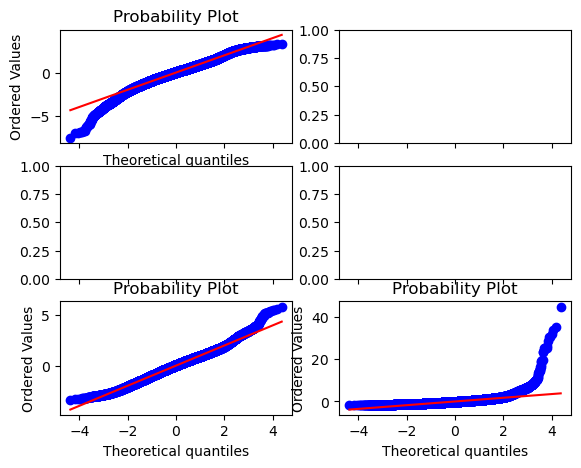

In [35]:
        ncols = 2
        fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)
        kk = 0
        ii = 0
        sps = sps.reshape((3, ncols))
'''
        data = (transformed_N0 - np.mean(
            transformed_N0)) / np.std(transformed_N0)
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)
        kk = 0
        ii = 1
        sps = sps.reshape((3, ncols))
'''
        data = (N0 - np.mean(
            N0)) / np.std(N0)
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)

'''
        kk = 1
        ii = 0
        sps = sps.reshape((3, ncols))

        data = (miu - np.mean(
            miu)) / np.std(miu)
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)
'''
        kk = 2
        ii = 0
        sps = sps.reshape((3, ncols))

        data = (transformed_sigma - np.mean(
            transformed_sigma)) / np.std(transformed_sigma)
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)
        kk = 2
        ii = 1
        sps = sps.reshape((3, ncols))

        data = (sigma - np.mean(
            sigma)) / np.std(sigma)
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)

In [56]:
def cal_error(s1,s2):
    corr = pd.Series(s1).corr(pd.Series(s2))
    corr = round(corr,2)
    #rmse = sqrt(mean_squared_error(pd.Series(s1),pd.Series(s2)))
    #rmse = round(rmse,2)
    ab = (s2-s1).mean()
    reletive_error = abs(s1-s2)
    reletive_error1 = reletive_error/s2
    return ab, corr

In [57]:
ab_e, corr  = cal_error(test[0,:][idx],  N0_retrieved)[:2]

In [58]:
ab_e

-0.062349692921691194

In [59]:
corr

0.89

In [120]:
np.array(N0_err).mean()

0.41014684586123157

In [60]:
    from scipy.stats import gaussian_kde
    #yy = np.array(psd_i_z)[none_i]
    yy = N0_retrieved
    xx = test[0,:][idx]
    ab_e, corr  = cal_error(xx, yy)[:2]

    xy = np.vstack([xx, yy])
    z = gaussian_kde(xy)(xy)

In [62]:
pearson_corr = np.corrcoef(xx, yy)[0,1]

# 计算JSD（需要先标准化预测和实际值）# y_test_hist：将实际值（y_test）分成20个区间，并计算每个区间的频率
y_test_hist, _ = np.histogram(xx, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# y_pred_hist：将预测值（y_pred）分成20个区间，并计算每个区间的频率
y_pred_hist, _ = np.histogram(yy, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# 计算JSD
jsd = jensenshannon(y_test_hist, y_pred_hist)
ab_e = cal_error(xx, yy)[:1]

Text(0.5, 0, '(a)True value of log$_{10}$(N0)')

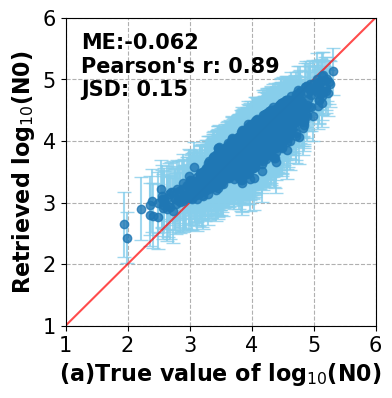

In [63]:
f  = plt.figure(figsize = (4,4))
ax = f.add_subplot()
#
#
plt.errorbar(xx, yy, yerr=N0_err, fmt='o', alpha = 0.8,ecolor='skyblue',capsize=5,capthick=1)
#plt.scatter(xx,yy,marker = 's', s = 16,c = z, cmap = 'Blues')
plt.plot([0,6],[0,6],c = 'red',alpha = 0.7)
plt.grid(True,linestyle = '--')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlim(1,6)
plt.ylim(1,6)
test_metrics_text = f"ME:{ab_e[0]: .3f}\nPearson's r: {pearson_corr:.2f}\nJSD: {jsd:.2f}"
ax.text(0.05, 0.95,f"{test_metrics_text}",transform=ax.transAxes,fontsize=15,fontweight='bold',verticalalignment='top',horizontalalignment='left',color='black')
plt.ylabel('Retrieved log$_{10}$(N0)',size  =16,fontweight='bold')
plt.xlabel('(a)True value of log$_{10}$(N0)',size = 16,fontweight='bold')
#plt.savefig('/home/penny/works/psd/results/wok05/OEM_method_demo_n0.png',bbox_inches = 'tight')

In [66]:
Dm_t = inv_boxcox(test[1,:][idx], lambda_value_sigma)
Dm_r = inv_boxcox(np.array(miu_retrieved), lambda_value_sigma)

In [67]:
pearson_corr = np.corrcoef(Dm_t, Dm_r)[0,1]

# 计算JSD（需要先标准化预测和实际值）# y_test_hist：将实际值（y_test）分成20个区间，并计算每个区间的频率
y_test_hist, _ = np.histogram(Dm_t, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# y_pred_hist：将预测值（y_pred）分成20个区间，并计算每个区间的频率
y_pred_hist, _ = np.histogram(Dm_r, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# 计算JSD
jsd = jensenshannon(y_test_hist, y_pred_hist)
ab_e = cal_error(Dm_t, Dm_r)[:1]

In [68]:
np.array(miu_err).mean()

0.15047591841289623

(0.0, 3.5)

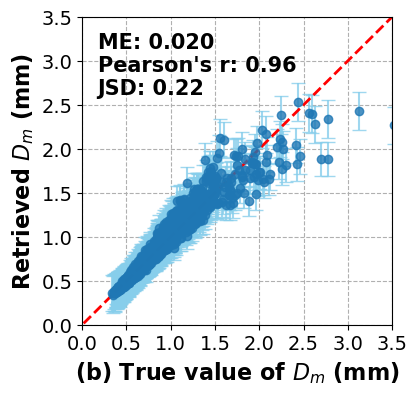

In [69]:
f  = plt.figure(figsize = (4,4))
ax = f.add_subplot()
#plt.scatter(test[1,:][idx], miu_retrieved,c = 'gray',s = 5)
#plt.plot([-1.5,1.5],[-1.5,1.5],c = 'red',alpha = 0.7)
plt.errorbar(Dm_t, Dm_r, yerr=miu_err, fmt='o', alpha = 0.8,ecolor='skyblue',capsize=5,capthick=1)
#sns.kdeplot(x=Dm_t, y=Dm_r, cmap='coolwarm', shade=True, ax = ax)
plt.plot([-1.5,4],[-1.5,4],c = 'red',linestyle = '--',linewidth = 2)
plt.grid(True,linestyle = '--')
plt.xticks(size = 14)
plt.yticks(size = 14)
test_metrics_text = f"ME:{ab_e[0]: .3f}\nPearson's r: {pearson_corr:.2f}\nJSD: {jsd:.2f}"
ax.text(0.05, 0.95,f"{test_metrics_text}",transform=ax.transAxes,fontsize=15,fontweight='bold',verticalalignment='top',horizontalalignment='left',color='black')
plt.ylabel('Retrieved $D_m$ (mm)',size  =16,fontweight='bold')
plt.xlabel('(b) True value of $D_m$ (mm)',size = 16,fontweight='bold')
plt.xlim(0,3.5)
plt.ylim(0,3.5)
#plt.savefig('/home/penny//works/psd/results/wok05/OEM_method_demo_dm.png',bbox_inches = 'tight')

In [109]:
N0_f = np.load('./results/wok05/2024_summer_surface_n0_1.npy')
N0_f = np.array([math.log10(x) for x in N0_f])
dm_f = np.load('./results/wok05/2024_summer_surface_dm_1.npy')
ts_f = np.load('./results/wok05/2024_summer_surface_tm_1.npy')
psd_i_v = np.load('./results/wok05/2024_summer_surface_vt_1.npy')
psd_i_z = np.load('./results/wok05/2024_summer_surface_ze_1.npy')

In [110]:
def argclosest(array, value, retvalue=False):
    """Returns the index of the closest value in array.  """
    idx = np.abs(array - value).argmin()

    return (idx, array[idx]) if retvalue else idx

In [111]:
psd_i_v.shape

(5891,)

In [ ]:
data = np.load('./results/wok05/retrieved_surface_n0_dm_un.npy')
N0_retrieved = data[0]
N0_err       = data[1]
Dm_r         = data[2]
miu_err      = data[3]

In [113]:
Dm_r = inv_boxcox(np.array(miu_retrieved), lambda_value_sigma)

In [127]:
pearson_corr = np.corrcoef(dm_f[idx],  Dm_r)[0,1]

# 计算JSD（需要先标准化预测和实际值）# y_test_hist：将实际值（y_test）分成20个区间，并计算每个区间的频率
y_test_hist, _ = np.histogram(dm_f[idx], bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# y_pred_hist：将预测值（y_pred）分成20个区间，并计算每个区间的频率
y_pred_hist, _ = np.histogram(Dm_r, bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# 计算JSD
jsd = jensenshannon(y_test_hist, y_pred_hist)
ab_e = cal_error(dm_f[idx], Dm_r)[:1]

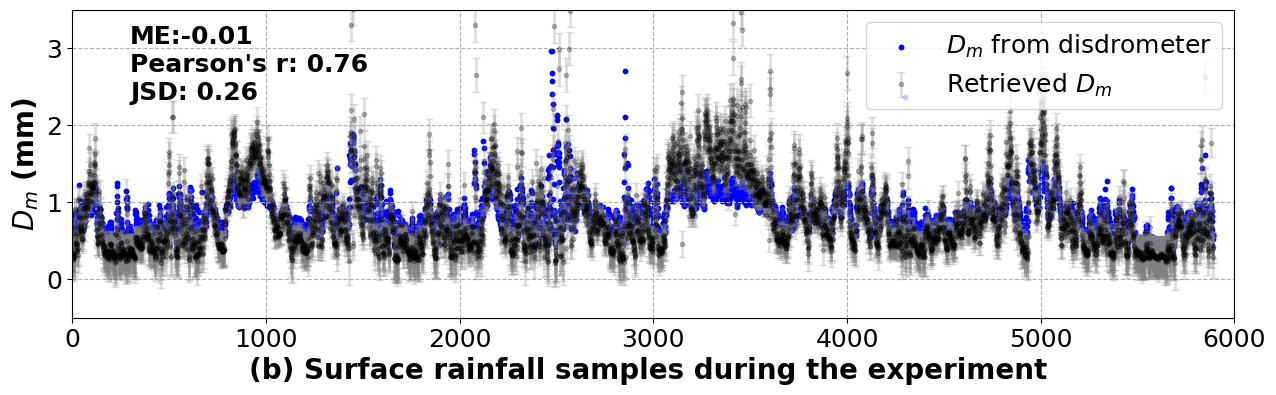

In [128]:
ab_e, corr  = cal_error(dm_f[idx],  Dm_r)[:2]
fig, ax = plt.subplots(figsize=(15,4))
plt.errorbar(range(len(dm_f[idx])), np.array(Dm_r), yerr=np.array(miu_err),fmt='o'"",ecolor='gray',color='k',elinewidth=2,capsize=3,ms=3,alpha=0.25,label = 'Retrieved $D_m$')
plt.scatter(range(len(dm_f[idx])), dm_f[idx],c='b',s = 10,label = '$D_m$ from disdrometer')
plt.legend()
plt.grid(linestyle = '--')
plt.legend(fontsize=18,loc = 1)
plt.ylim(-0.5,3.5)
plt.xlim(-1,6000)
test_metrics_text = f"ME:{ab_e: .2f}\nPearson's r: {pearson_corr:.2f}\nJSD: {jsd:.2f}"
ax.text(0.05, 0.95,f"{test_metrics_text}",transform=ax.transAxes,fontweight='bold',fontsize=18,verticalalignment='top',horizontalalignment='left',color='black')
plt.tick_params(labelsize = 18)
#plt.text(0,0.65, '平均反演不确定度 = '+ str(abs(un))+' (kg/m$^2$)',size = 20)
plt.ylabel('$D_m$ (mm)',size = 20,fontweight='bold')
plt.xlabel('(b) Surface rainfall samples during the experiment ',size = 20,fontweight='bold')
plt.savefig('/home/penny//works/psd/results/wok05/surface_re_val_dm.png',bbox_inches = 'tight')

In [129]:
pearson_corr = np.corrcoef(N0_f[idx], np.array(N0_retrieved))[0,1]

# 计算JSD（需要先标准化预测和实际值）# y_test_hist：将实际值（y_test）分成20个区间，并计算每个区间的频率
y_test_hist, _ = np.histogram(N0_f[idx], bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# y_pred_hist：将预测值（y_pred）分成20个区间，并计算每个区间的频率
y_pred_hist, _ = np.histogram(np.array(N0_retrieved), bins=20, density=True) # 'bins=20'将数据分为20个区间，'density=True'使得每个区间的值归一化为概率密度
# 计算JSD
jsd = jensenshannon(y_test_hist, y_pred_hist)
ab_e = cal_error(N0_f[idx], np.array(N0_retrieved))[:1]

In [124]:
ab_e

(0.12098736727443006,)

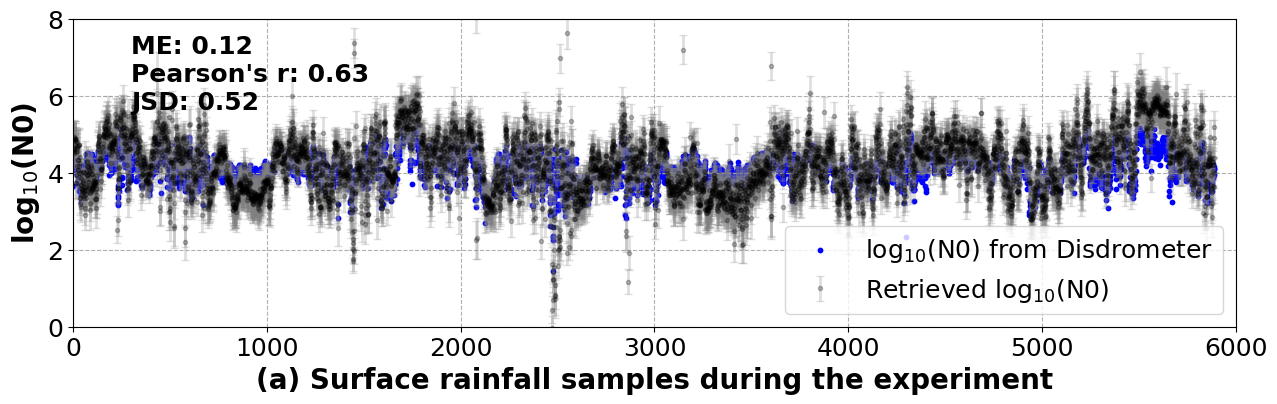

In [126]:
fig, ax = plt.subplots(figsize=(15,4))
plt.errorbar(range(len(N0_f[idx])), np.array(N0_retrieved), yerr=np.array(N0_err),fmt='o'"",ecolor='gray',color='k',elinewidth=2,capsize=3,ms=3,alpha=0.25,label = 'Retrieved log$_{10}$(N0)')
plt.scatter(range(len(N0_f[idx])), N0_f[idx],c='blue',s = 10,label = 'log$_{10}$(N0) from Disdrometer')
plt.legend()
plt.grid(linestyle = '--')
plt.legend(fontsize=18,loc =4)
plt.tick_params(labelsize = 18)
plt.xlim(-1,6000)
plt.ylim(0,8)
test_metrics_text = f"ME:{ab_e[0]: .2f}\nPearson's r: {pearson_corr:.2f}\nJSD: {jsd:.2f}"
ax.text(0.05, 0.95,f"{test_metrics_text}",transform=ax.transAxes,fontweight='bold',fontsize=18,verticalalignment='top',horizontalalignment='left',color='black')
plt.tick_params(labelsize = 18)
plt.ylabel('log$_{10}$(N0)',size = 20,fontweight='bold')
plt.xlabel('(a) Surface rainfall samples during the experiment',size = 20, fontweight='bold')
plt.savefig('/home/penny//works/psd/results/wok05/surface_re_val_n0.png',bbox_inches = 'tight')

In [274]:
np.vstack((np.array(N0_retrieved),np.array(N0_err)))

array([[4.98973278, 4.833373  , 4.74325804, ..., 6.18213116, 6.50121437,
        5.96085698],
       [0.37169264, 0.38027286, 0.39263015, ..., 0.46148449, 0.35765596,
        0.43330905]])

In [275]:
retrieved = np.vstack((np.array(N0_retrieved),np.array(N0_err)))
retrieved = np.vstack((retrieved,np.array(Dm_r)))
retrieved = np.vstack((retrieved,np.array(miu_err)))

In [277]:
np.save('./results/wok05/retrieved_surface_n0_dm_un',retrieved)